## 데이터셋 구경

In [1]:
import pandas as pd

df=pd.read_csv('data/metadata_with_Nan.csv')

filter = df[df['Shape_Feature'].isin(['C '])]

filter

,Name,Upper,Category,Shape_Feature,Description
12,BL-001,T,BL,C,스카이 블루 페일 톤 단색
29,BL-002,T,BL,C,아이보리 단색
51,BL-003,T,BL,C,화이트 단색
74,BL-004,T,BL,C,화이트 단색
92,BL-005,T,BL,C,화이트 단색
...,...,...,...,...,...
116967,VT-272,O,VT,C,아이보리 단색
116968,VT-272,O,VT,C,상의 가슴 부분 왼쪽 브라운 대비 색 포인트 배색
116969,VT-272,O,VT,C,상의 암홀 부분 브라운 대비 색 포인트 배색
116970,VT-272,O,VT,C,상의 앞 중심선 부분 오른쪽 브라운 대비 색 포인트 배색


## Feature Extraction - Clustering

In [3]:
import pandas as pd
from torch.utils.data import DataLoader

df=pd.read_csv('data/metadata_with_Nan.csv')
names = set(list(df['Name']))
names = pd.DataFrame(names, columns=['Name'])

In [4]:
from tools.Fashiondataset import FashionDataset

image_folder = 'data/img_jpg'
Dataset=FashionDataset(dataframe=names, image_folder=image_folder)
Dataloader=DataLoader(Dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용하는 장치: {device}")

사용하는 장치: cuda


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image
from tools.ExtractFeature import extract_features_from_images, get_features
from tools.clustering import perform_clustering_with_cache

def visualize_in_3d_with_scree_plot(features, labels):
    pca_full = PCA().fit(features)
    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
    n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
    n_components_70 = np.argmax(cumulative_variance >= 0.7) + 1
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.grid()
    
    plt.axvline(x=n_components_90, color='red', linestyle='--', label=f'90% Variance at PC {n_components_90}')
    plt.axvline(x=n_components_80, color='green', linestyle='--', label=f'80% Variance at PC {n_components_80}')
    plt.axvline(x=n_components_70, color='blue', linestyle='--', label=f'70% Variance at PC {n_components_70}')
    plt.legend()
    plt.show()
    
    pca = PCA(n_components=3)
    features_3d = pca.fit_transform(features)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], 
                         c=labels, cmap='tab20c', s=15)
    
    ax.set_title('Clustered Feature 3D Visualization')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    
    legend = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend)
    
    plt.show()

In [20]:
user_name='default'
model = 'deit' # ['resnet', 'vit', 'dino', 'deit']

features_deit = get_features(user_name, model, Dataloader, force_extract=False)

deit extracted feature load from saved/default_features_deit.npy.


In [21]:
original_labels = perform_clustering_with_cache(user_name, features_deit, model_type='deit', n_clusters=13, force_cluster=False)

default clustered labels were load from saved/default_labels_deit_13clusters.npy.


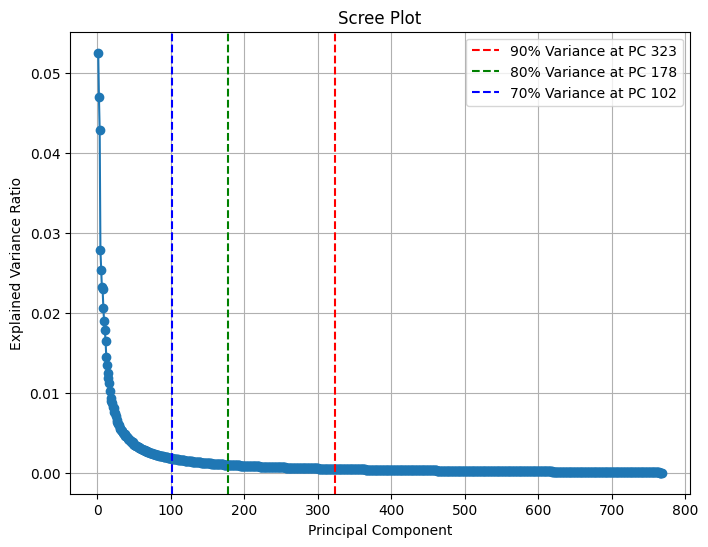

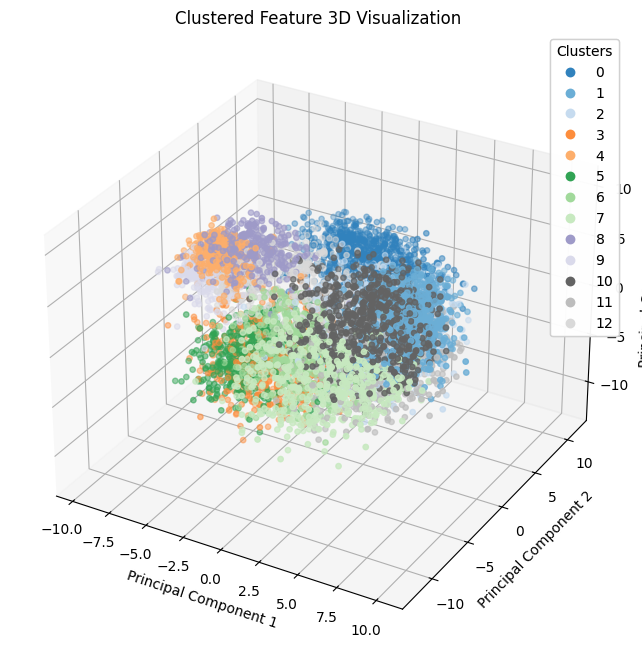

In [22]:
len(original_labels)
visualize_in_3d_with_scree_plot(features_deit,original_labels)

## Similarity check

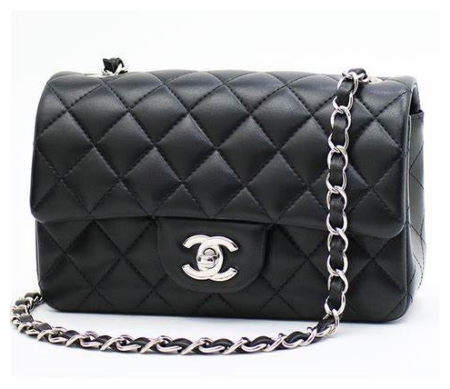

In [23]:
img_path = 'data/preference/CH-test1.jpg'
image = Image.open(img_path).convert('RGB')
plt.imshow(image)
plt.axis('off') 
plt.show()

In [24]:
from tools.Extractor import FeatureExtractor

feature_image = extract_features_from_images([img_path], FeatureExtractor(model_type=model).to(device), device, transform=True)

Feature extraction: 100%|██████████| 1/1 [00:00<00:00, 26.36it/s]



추천 결과:
1개의 유사한 아이템이 있습니다.

상위 5개 아이템 유사도:
1번째 아이템: 73.87999725341797%
2번째 아이템: 67.91999816894531%
3번째 아이템: 65.7300033569336%
4번째 아이템: 64.62000274658203%
5번째 아이템: 64.5199966430664%


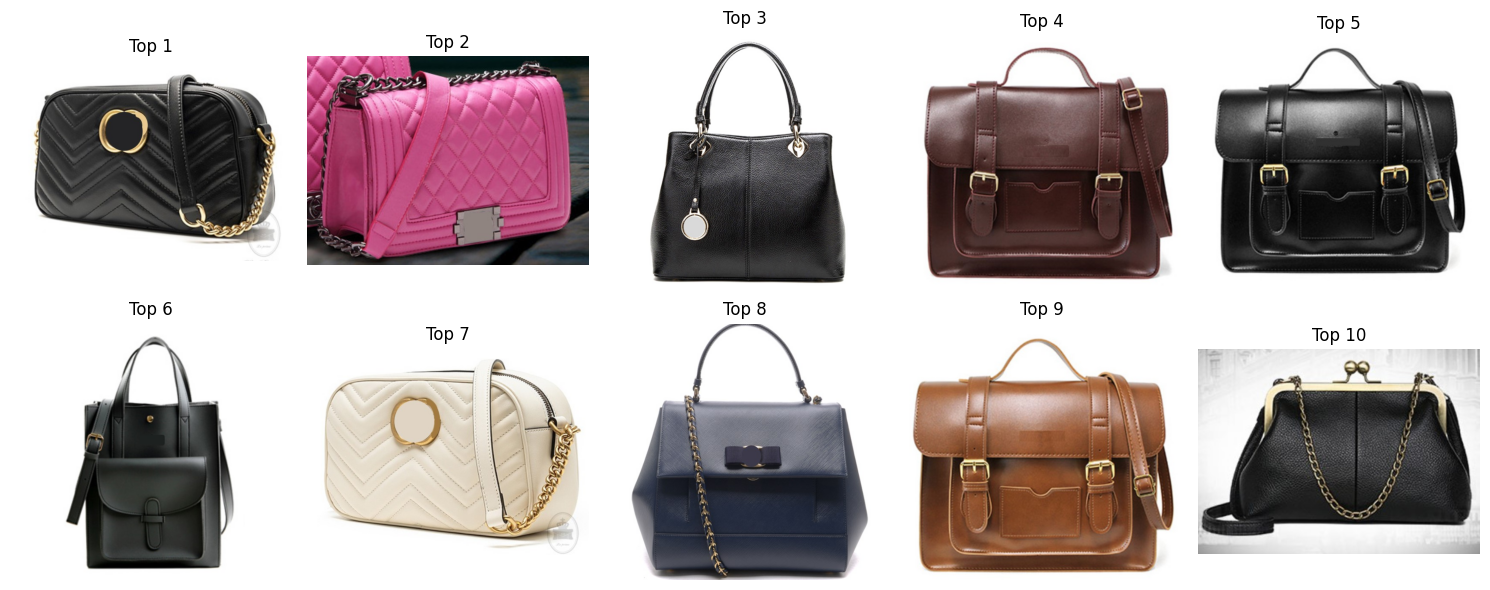

In [25]:
from tools.similarity import Similarity
sim = Similarity(features_deit, Dataset)
a=sim.get_sim(feature_image, k=10)
percentages, recommendation = sim.attractiveness(feature_image, return_percentage=True)

print("\n추천 결과:")
print(recommendation)

print("\n상위 5개 아이템 유사도:")
for i, percent in enumerate(percentages[0][:5], 1):
    print(f"{i}번째 아이템: {percent}%")
Dataset.show_images(a)